In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set()

LOADING THE DATASET

In [2]:
ckd= pd.read_csv('kidney_disease_complete_2c.csv')


In [3]:
ckd.isnull().sum()

age               0
diastolic bp      0
sg                0
al                0
su                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
rbc               0
pc                0
pcc               0
ba                0
htn               0
dm                0
cad               0
pe                0
ane               0
classification    0
dtype: int64

CHECKING THE DISTRIBUTION OF CLASSIFICATION VARIABLES

In [4]:
ckd['classification'].value_counts()

classification
0    230
1    140
Name: count, dtype: int64

FIXING DATA TYPE ERRORS

In [5]:
ckd.dtypes

age                 int64
diastolic bp        int64
sg                float64
al                  int64
su                  int64
bgr                 int64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                 int64
wc                  int64
rc                float64
rbc                 int64
pc                  int64
pcc                 int64
ba                  int64
htn                 int64
dm                  int64
cad                 int64
pe                  int64
ane                 int64
classification      int64
dtype: object

In [6]:
ckd.select_dtypes(exclude=["object"]).columns

Index(['age', 'diastolic bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod',
       'pot', 'hemo', 'pcv', 'wc', 'rc', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm',
       'cad', 'pe', 'ane', 'classification'],
      dtype='object')

CHANGING ALL INTEGER VALUES TO FLOAT

In [7]:
for i in ckd.select_dtypes(exclude=["object"]).columns:
  ckd[i]=ckd[i].apply(lambda x: float(x))

In [8]:
ckd.dtypes

age               float64
diastolic bp      float64
sg                float64
al                float64
su                float64
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv               float64
wc                float64
rc                float64
rbc               float64
pc                float64
pcc               float64
ba                float64
htn               float64
dm                float64
cad               float64
pe                float64
ane               float64
classification    float64
dtype: object

CONVERTING CATEGORICAL VALUES TO NUMERICAL VALUES

FINDING THE CORRELATION

<Axes: >

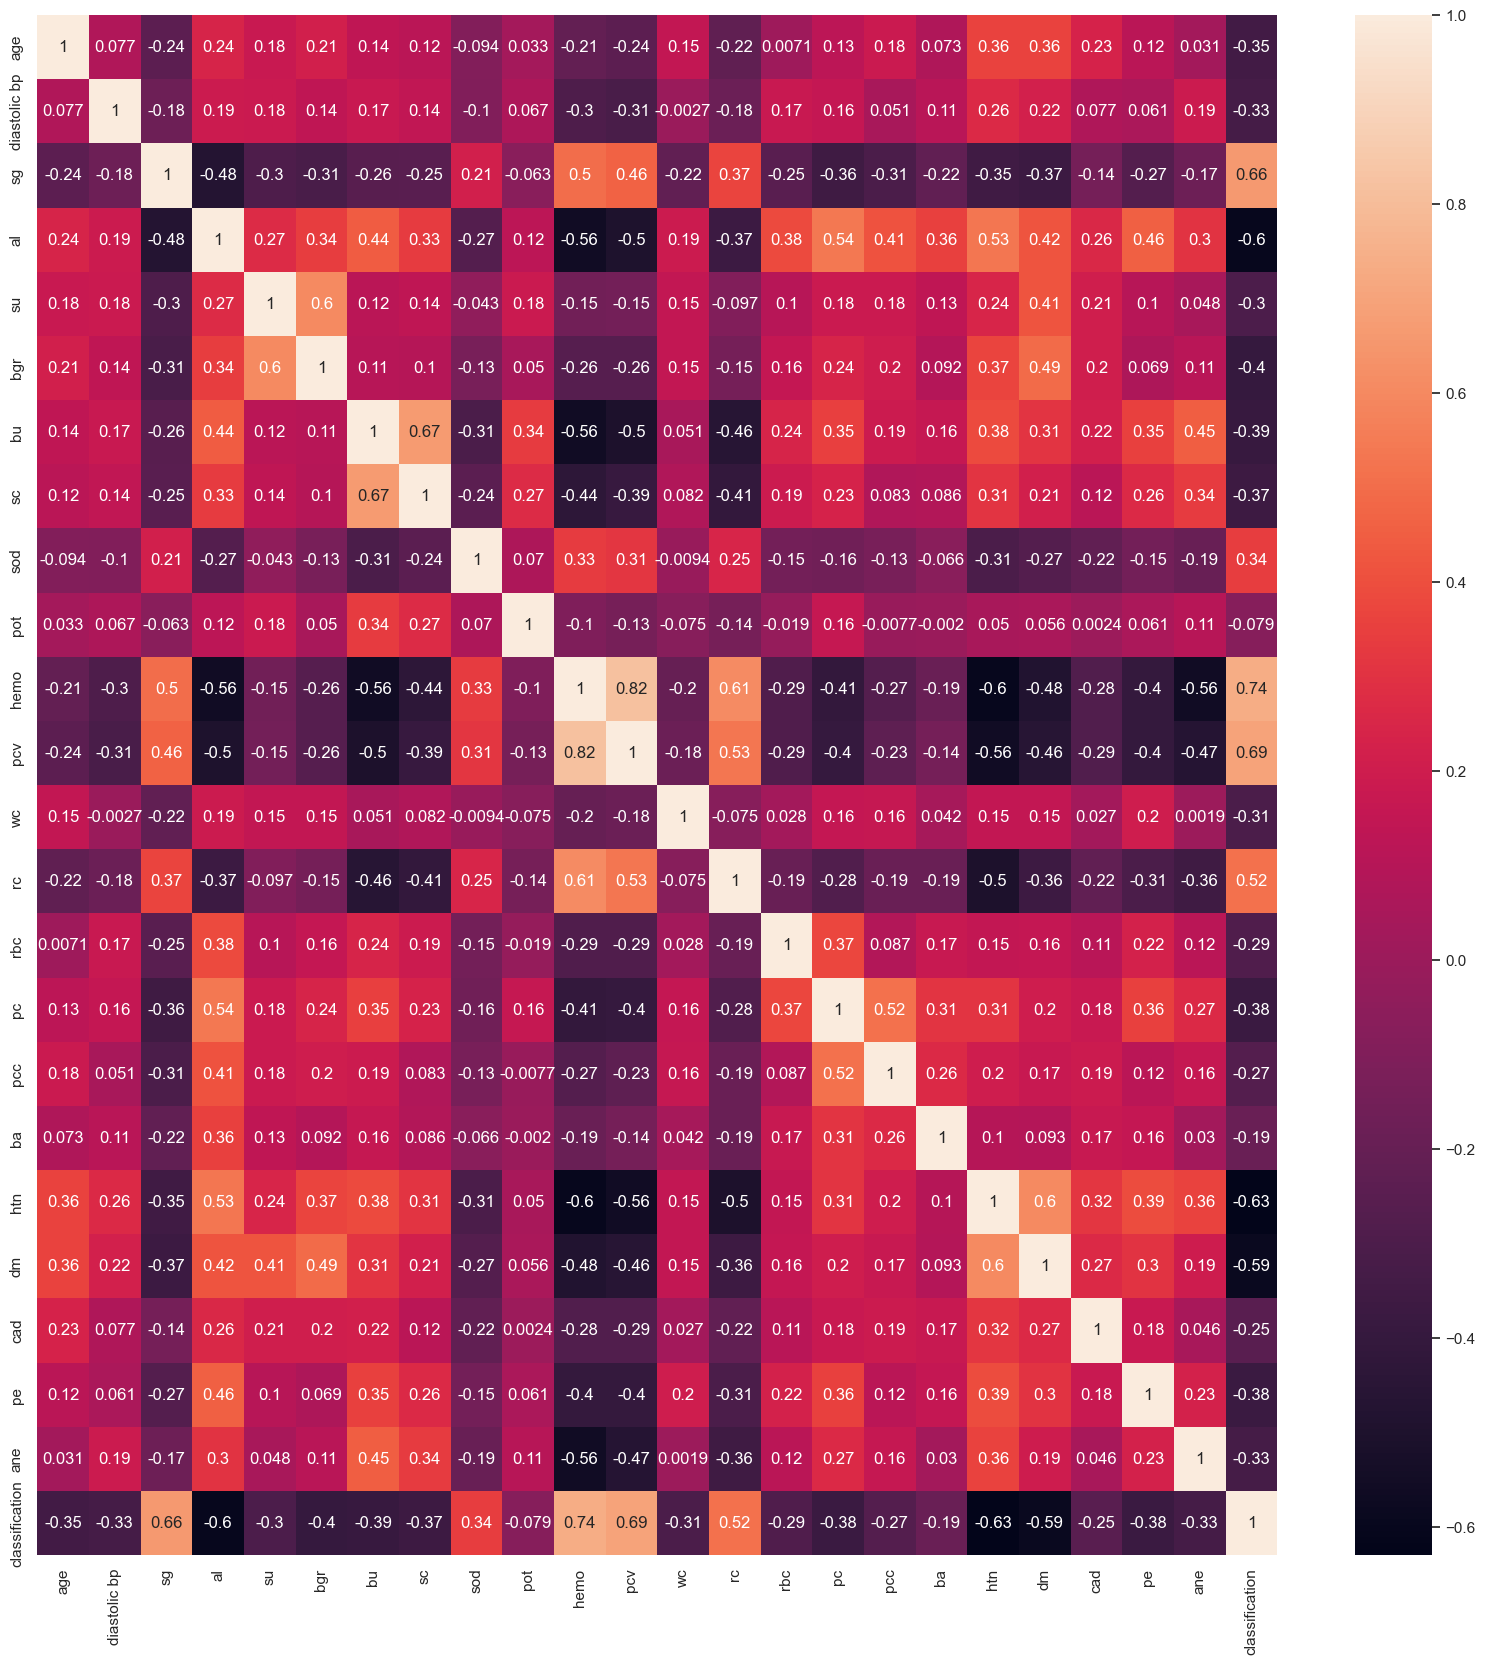

In [9]:
plt.figure(figsize=(20,20))
#corr=ckd_enco.corr()
corr=ckd.corr()
sns.heatmap(corr, annot=True)

FEATURE ENGINEERING

In [10]:
x=ckd.drop(["classification"],axis=1)
y=ckd["classification"]




DETECTING LABEL IMBALANCE

In [11]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

print(Counter(y))

Counter({0.0: 230, 1.0: 140})


In [12]:
#balancing the labels

ros= RandomOverSampler()

X_ros, y_ros = ros.fit_resample(x,y)
print(Counter(y_ros))

Counter({0.0: 230, 1.0: 230})


NORMALIZING THE DATA

In [13]:
#Initialize a MinMaxScalar and scale the features to between -1 and 1 to normalize them.
#MinMaxScaler transforms features by scaling them to a given range.
#The fit_transform() method fits to the data and then transforms it. We don't need to scales the labels.
#Scale the features to between -1 and 1

#Scaling is important in the algorithms such as support vector machines(SVM) and k-nearest neighbors(KNN) where distance
#between the data points is important.

scaler=MinMaxScaler((-1,1))
x=scaler.fit_transform(X_ros)
y=y_ros

PCA

In [14]:
#used for dimensionality reduction and data visualization.
#The code below has .95 for the number of components parameter.
#It means that scikit-learn choose the minimum number of principal components such that 95% of the variance is retained

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.decomposition import PCA

pca = PCA(.95)
X_PCA=pca.fit_transform(x)

print(x.shape)
print(X_PCA.shape)

#we need 18 columns to keep a variance of 95%

(460, 23)
(460, 15)


In [15]:
#With PCA
#Split the dataset into training and testing sets keeping 20% of the data for testing.
#Split the dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_PCA,y, test_size=0.2, random_state=7)

RNN MODEL

In [16]:
import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout

def rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(15, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','precision'])
    
    return model

In [17]:
x_train_reshaped = x_train[..., np.newaxis]
x_test_reshaped = x_test[..., np.newaxis]

In [18]:
model = rnn_model(input_shape=(x_train.shape[1], 1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │           765 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,381 (13.21 KB)

 Trainable params: 3,381 (13.21 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(x_train[..., np.newaxis], y_train, validation_data=(x_test[..., np.newaxis], y_test), epochs=5, batch_size=15, verbose=1)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.4742 - loss: 0.6712 - precision: 0.4940 - val_accuracy: 0.5326 - val_loss: 0.5260 - val_precision: 1.0000
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6916 - loss: 0.4498 - precision: 0.9382 - val_accuracy: 0.9239 - val_loss: 0.4110 - val_precision: 0.9038
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9258 - loss: 0.3428 - precision: 0.8987 - val_accuracy: 0.9130 - val_loss: 0.3735 - val_precision: 0.8596
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9620 - loss: 0.3747 - precision: 0.9439 - val_accuracy: 0.9130 - val_loss: 0.3433 - val_precision: 0.8596
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9579 - loss: 0.3010 - precision: 0.9320 - val_accuracy: 0.9239 - val_loss: 0.2514 - val_precision: 0.8750


MODEL LOSS AND ACCURACY

In [20]:
result = model.evaluate(x_test_reshaped, y_test)
print("Result:", result)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9307 - loss: 0.2573 - precision: 0.8893 
Result: [0.2513643205165863, 0.9239130616188049, 0.875]


In [21]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score,precision_recall_fscore_support, f1_score, confusion_matrix

def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    fig, c_ax = plt.subplots(1, 1, figsize=(8, 6))
    c_ax.plot(fpr, tpr, label='%s [AUC:%0.2f]' % ('classification', auc(fpr, tpr)))
    c_ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()

In [22]:
def plot_precision_recall_curve_helper(t_y, p_y):
    fig, c_ax = plt.subplots(1, 1, figsize=(8, 6))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    aps = average_precision_score(t_y, p_y)
    c_ax.plot(recall, precision, label='%s (AP Score:%0.2f)' % ('classification', aps))
    c_ax.plot(recall, precision, color='red', lw=2)
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    plt.show()

In [23]:
def plot_history(history):
    f = plt.figure()
    f.set_figwidth(15)
    f.add_subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()
    plt.title("MODEL LOSS")
    f.add_subplot(1, 2, 2)
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.legend()
    plt.title("MODEL ACCURACY")
    plt.show()

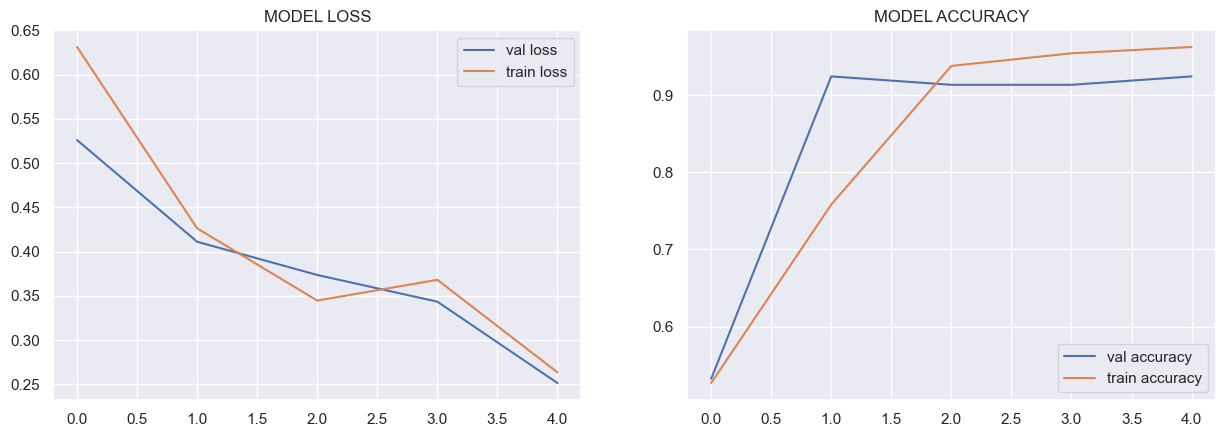

In [24]:
plot_history(history)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


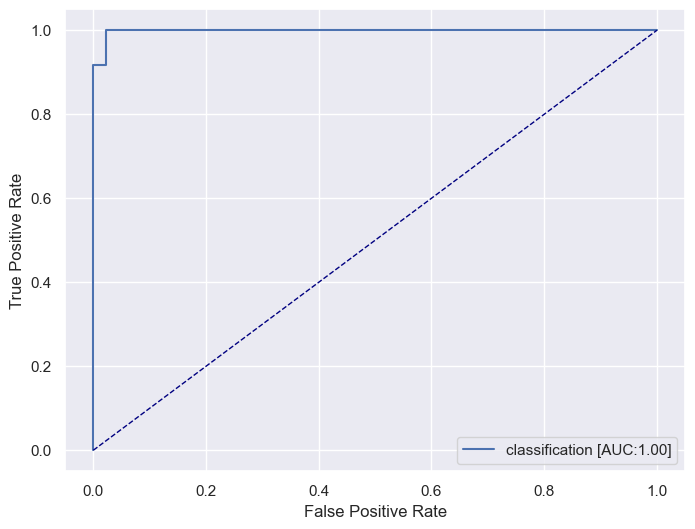

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


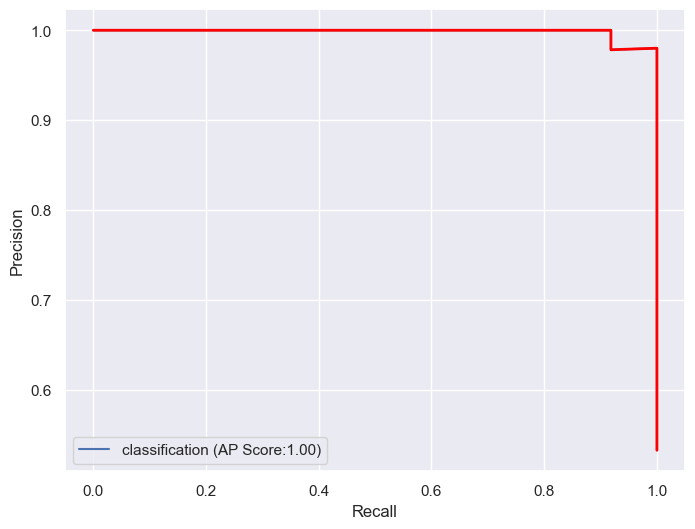

In [25]:
plot_auc(y_test, model.predict(x_test_reshaped, verbose=True))
plot_precision_recall_curve_helper(y_test, model.predict(x_test_reshaped, verbose=True))

MODEL OPTIMIZATION

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9307 - loss: 0.2573 - precision: 0.8893 
[loss,accuracy,precision]: [0.2513643205165863, 0.9239130616188049, 0.875]


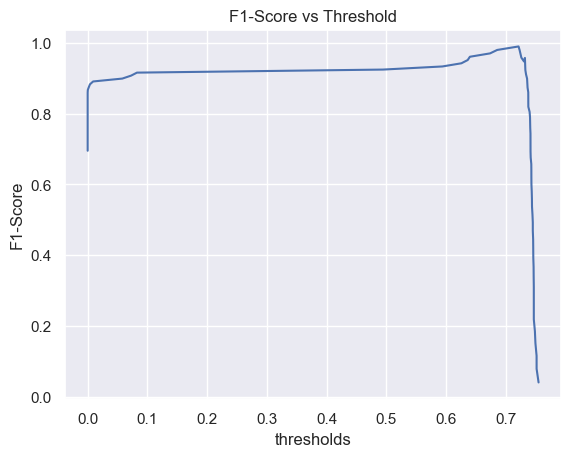

In [26]:
def calc_f1(prec, recall):
    return 2 * (prec * recall) / (prec + recall) if recall and prec else 0

precision, recall, thresholds = precision_recall_curve(y_test, model.predict(x_test_reshaped, verbose=True))
f1score = [calc_f1(precision[i], recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1score)
threshold = thresholds[idx]

"""loss, accuracy = model.evaluate(x_test_reshaped, y_test)
print('----------------------------------------------')
print('Precision: ' + str(precision[idx]))
print("Accuracy:", accuracy)
print("Loss:", loss)
print('Recall: ' + str(recall[idx]))
print('Threshold: ' + str(thresholds[idx]))
print('F1 Score: ' + str(f1score[idx]))"""

result = model.evaluate(x_test_reshaped, y_test)
print("[loss,accuracy,precision]:", result)

plt.figure()
plt.plot(thresholds, f1score)
plt.title("F1-Score vs Threshold")
plt.xlabel("thresholds")
plt.ylabel("F1-Score")
plt.show()

PREDICTION AND INTERPRETATION

In [27]:
# User Input Functionality
def get_user_input():
    user_data = {}    
    for column in ckd.columns[:-1]:  # This doesn't include the classification column
        user_data[column] = float(input(f"Enter value for {column}: "))
    return user_data


def preprocess_input(user_data):
    user_df = pd.DataFrame(user_data, index=[0])
    user_scaled = scaler.transform(user_df)
    user_pca = pca.transform(user_scaled)
    return user_pca

def interpret(prediction, threshold=0.5):
    if prediction >= threshold:
        return "The patient is likely suffering from CKD"
    else:
        return "Healthy kidney"
    
user_data = get_user_input()
user_input_processed = preprocess_input(user_data)
prediction = model.predict(user_input_processed)[0][0]
result = interpret(prediction)

threshold = 0.5 
if prediction >= threshold:
   prediction = f"The patient could be suffering from Chronic Kidney Disease with a prediction probability of {prediction*100:.2f}% "
else:
    prediction = "The patient has a healthy kidney with a prediction probability of {:.2f}%".format((1 - prediction) * 100)

print(f"Prediction: {prediction} \n")

#DIET SUGGESTION BASED ON PREDICTION
def diet_plan(result):
    if result == "The patient is likely suffering from CKD" :
        diet_suggestion = """
        To improve your condition, do the following:
        
        - Consult with a dietitian for a personalized plan.
        - Drink adequate water, but not excessively.
        - Minimize intake of fizzy drinks.
        - Avoid alcohol
        - Limit protein intake to reduce the workload on kidneys.
        - Choose high-quality protein sources like fish, poultry, and eggs.
        - Reduce sodium intake to control blood pressure.
        - Limit foods high in phosphorus such as dairy, nuts, seeds.
        - Limit potassium-rich foods such as bananas, oranges, potatoes.
        
        """
        
    if result == "Healthy kidney":
        diet_suggestion = """
        Diet Suggestions for Healthy Kidneys:
        
        - Eat plenty of fruits and vegetables.
        - Minimize intake of fizzy drinks.
        - Minimize alcohol intake
        - Maintain a balanced diet with a variety of foods.
        - Ensure adequate hydration by drinking enough water.
        - Include whole grains and lean proteins.
        - Limit intake of processed foods and high-sodium snacks.
        - Avoid excessive amounts of sugar and saturated fats.
        """
    return diet_suggestion

import time
import sys

def animate_text(text):
    for char in text:
        sys.stdout.write(char)
        sys.stdout.flush()
        time.sleep(0.03)  # Adjusting speed of animation

diet_suggestion = diet_plan(result)
 # Change text color to green
sys.stdout.write("\033[92m")
animate_text("Generating diet suggestions per the prediction...\n")
# Change text color to white
sys.stdout.write("\033[0m")
animate_text(diet_suggestion)

ValueError: could not convert string to float: ''